#Import libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Fruits (2).zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pytorch-fid
!pip install torchmetrics
!pip install torch-fidelity
!pip install torchinfo 
!pip install matplotlib==3.5 #with newer versions of matplotlib this notebook might not run
%matplotlib inline
!pip install captum==0.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from matplotlib import cm
from matplotlib import patches
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
from torch.utils.data import Subset
from PIL import Image
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import cv2
import torchvision.transforms as T
import torchvision.transforms.functional as F
import time
from torch.utils.data import random_split
from collections import Counter
import datetime
from torchvision.utils import make_grid
import torch.optim as optim
from matplotlib import gridspec
from numpy import linspace
from numpy.random import randn
from numpy import asarray
from torch.nn import functional as F
from tqdm import tqdm
import IPython.display
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
import PIL.Image
import io
import shutil
from IPython.display import HTML
from pytorch_fid.fid_score import calculate_fid_given_paths
import uuid
import shutil
import torch_fidelity
from torchmetrics.image.inception import InceptionScore
from torchvision.utils import save_image
from torch.utils.data import ConcatDataset, DataLoader
from torchinfo import summary


#from PIL import Image


#We can use our GPU if it's available
print(torch.cuda.is_available())
dev = torch.device('cuda')
print(dev)

True
cuda


# Initialization and visualization of our data

## Class initialization

In [5]:
class Fruits(Dataset):
  def __init__(self, image_dir, transforms=None): 
        #super().__init__()
    self.transforms = transforms
    self.files = []

    split = "train"
    self.image_dir = Path(image_dir)/split
    folders = sorted(os.listdir(self.image_dir))
    for folder in folders:
      class_idx = folders.index(folder)
      folder_dir = self.image_dir/folder
      files = os.listdir(folder_dir)
      self.files += [{"file": folder_dir/x, "class": class_idx} for x in files]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    item = self.files[i]
    file = str(item['file'])
    class_idx = (item['class'])

    img = Image.open(file).convert("RGB")
    if self.transforms != None:
      img = self.transforms(img)
      return img, class_idx , file
    img = T.ToTensor()(img)
    return img, class_idx , file

# ANOTHER WAY TO VISUALIZE THE IMAGE IS TRHOUGH cv2
    # reading the images and converting them to correct size and color
 #   img = cv2.imread(str(file))
 #   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)  #cv2 reads in BGR, change to RGB
 #   img /= 255 # diving by 255, needed to visualize correctly the images
 #   img = T.ToTensor()(img)
 #   img = self.transforms(img)

###########################
#def collate_fn(batch):
#    return tuple(zip(*batch))



## Explorative data analysis

dict_items([('Banana', 490), ('Corn', 450), ('Kiwi', 466), ('Orange', 479), ('Pineapple', 490)])


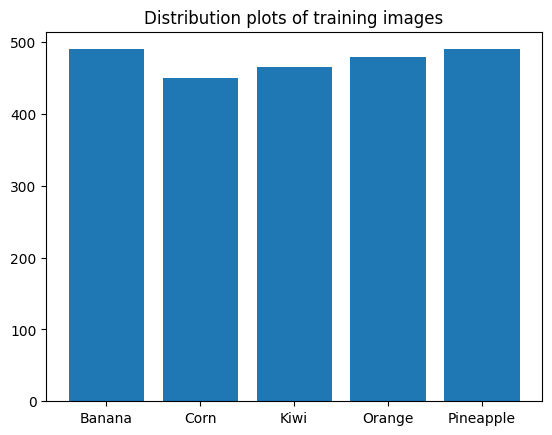

In [ ]:
image_dir = "/tmp/Fruits"
dataset = Fruits(image_dir, transforms=None)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last = True, num_workers = 2)


#get a distribution and show the results in a barplot
classes = np.array([class_idx for _, class_idx, _ in dataset])

c = Counter(classes)
replacement = {0:'Banana', 1: 'Corn', 2: 'Kiwi', 3: 'Orange', 4: 'Pineapple'}
for k, v in list(c.items()):
    c[replacement.get(k, k)] = c.pop(k)
print(c.items()) 
plt.bar(list(c.keys()), list(c.values()))
plt.title('Distribution plots of training images')
plt.show()

## Visualization of images

In [ ]:
def showarray(a, b = None, fmt='png', title1 = None, title2 = None):
    a = (a - a.min())
    a = a /a.max()
    a = np.uint8(a*255)

    fa = io.BytesIO()
    PIL.Image.fromarray(a).save(fa, fmt)
    if(b!=None):
      b = (b - b.min())
      b = b / b.max()
      b = np.uint8(b * 255)
      fb = io.BytesIO()
      PIL.Image.fromarray(b).save(fb, fmt)
      fig, ax = plt.subplots(1, 2, figsize=(15, 15))
      ax[0].set_xticks([]); ax[0].set_yticks([])
      ax[1].set_xticks([]); ax[1].set_yticks([])
      ax[0].imshow(a)
      ax[0].title.set_text(title1)
      ax[1].imshow(b)
      ax[1].title.set_text(title2)
      plt.show()
    else:
      fig, ax = plt.subplots(figsize=(8, 8))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(a)
      ax.title.set_text(title1)
      plt.show()
  # IPython.display.display(IPython.display.Image(data=fa.getvalue(), width=width, height=height))
  # IPython.display.display(IPython.display.Image(data=fb.getvalue(), width=width, height=height))


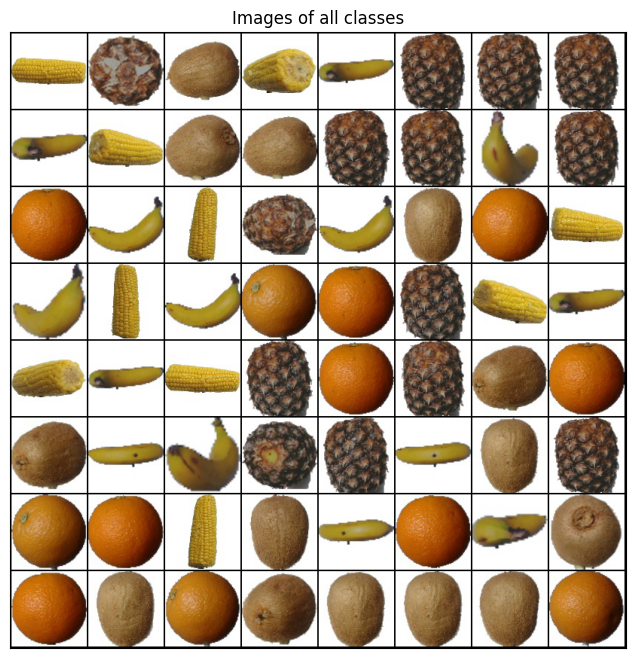

In [ ]:
grid_img_normal = vutils.make_grid(next(iter(dataloader))[0], nrow=8)
showarray(grid_img_normal.permute(1, 2, 0), title1 = "Images of all classes")

# GAN

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # This will generate a random seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Generate images 64x64

In [40]:
image_size = 64
n_classes = 5
embedding_dim = 100
z_dim = 100  #latent dim
outf = "output"

In [41]:
transform = T.Compose([
    T.Resize((image_size,image_size)),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
image_dir = "/tmp/Fruits"
dataset = Fruits(image_dir, transforms=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last = True, num_workers = 2)

In [42]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))

        self.latent = nn.Sequential(nn.Linear(z_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),  #in_channels, out_channels, kernel_size, stride, padding
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 3, 4, 2, 1, bias=False), #3 because our final image has 3 channels
                      nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512, 4, 4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        return image



##########################################
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*64*64))

        self.model = nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),    #in_channels, out_channels, kernel_size, stride, padding,
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(64*8*8*4, 1),
                      nn.Sigmoid())
        

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 64, 64)
        concat = torch.cat((img, label_output), dim=1)
        output = self.model(concat)
        return output

####################################
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

# Create discriminator and generator
generator = Generator().to(dev)
generator.apply(weights_init)
discriminator = Discriminator().to(dev)
discriminator.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Define the optimizers for the generator and discriminator models
G_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

def generator_loss(label, fake_output):
    gen_loss = criterion(label, fake_output)
    #print(gen_loss)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = criterion(label, output)
    #print(total_loss)
    return disc_loss

## Train

In [ ]:
num_epochs = 2000
D_loss_plot, G_loss_plot, all_fid = [], [], []

if os.path.exists("Training_images"):
  shutil.rmtree('Training_images')

transform_fid = T.Compose([
    T.Resize((image_size,image_size))])

image_dir = "/tmp/Fruits"
training_fid = Fruits(image_dir, transforms=transform_fid) 

os.makedirs('Training_images')
for idx in tqdm(range(len(training_fid))):
  img, label, _ = training_fid.__getitem__(idx)
  img.save(f"Training_images/{idx}.png")

100%|██████████| 2375/2375 [00:04<00:00, 587.63it/s]


In [ ]:
if os.path.exists("image_created"):
  shutil.rmtree('image_created')

if os.path.exists(outf):
  shutil.rmtree(outf)

try:
    os.makedirs(outf)
except OSError:
  pass   

def normalize_images_IS(images): #IS wants input between [0,1]
    # Normalize a batch of images to be between 0 and 1
    max_value = torch.max(images)
    min_value = torch.min(images)
    normalized_images = (images - min_value) / (max_value - min_value)
    return normalized_images

for epoch in range(1, num_epochs+1): 
 
    D_loss_list, G_loss_list = [], []
    
    for index, (real_images, labels, _) in enumerate(dataloader):
        D_optimizer.zero_grad()
        # Real Data
        real_images = real_images.to(dev)
        # Real labels
        labels = labels.to(dev)
        labels = labels.unsqueeze(1).long()
 
        #Real and fake labels (real = 1, fake = 0)
        real_target = torch.ones(real_images.size(0), 1).to(dev)
        fake_target = torch.zeros(real_images.size(0), 1).to(dev)
       
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
     
        # Create the noise (starting of the fake images)
        noise_vector = torch.randn(real_images.size(0), z_dim, device=dev)  
        noise_vector = noise_vector.to(dev)
         
        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)
 
        # train with fake       
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
       
        D_total_loss.backward()
        D_optimizer.step()
 
        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)
 
        G_loss.backward()
        G_optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
      vutils.save_image(real_images[0], '%s/real_samples.png' % outf, normalize=True) 
      #  fake = generator(noise_vector)
      vutils.save_image(generated_image.detach(), '%s/fake_samples_epoch_%03d.png' % (outf, epoch), normalize=True)
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    
    #FID and IS calculated every 250 epochs
    if epoch % 250 == 0 or epoch == 1:
      try:
        os.makedirs("image_created")
      except OSError:
        pass  
      for _ in tqdm(range(37)):  #like dataloader
        with torch.no_grad():
          noise_vector = torch.randn(64, z_dim, device=dev)   #64 is the batch, ma è come se fossero righe e z_dim le colonne. Aggiornando sempre il noise vector, facciamo si che per ogni batch il noise di partenza sa diverso  quindi gneera immagini diverse per ogni batch
          fake_imgs = generator((noise_vector, labels))  
        for idx in range(fake_imgs.shape[0]):
          fake_img= fake_imgs[idx]
          vutils.save_image(fake_img,f"image_created/{str(uuid.uuid4())}.png",normalize=True)
      fid = calculate_fid_given_paths(['Training_images','image_created'],dims=2048, device = 'cuda',batch_size=64)
      fake_imgs = normalize_images_IS(fake_imgs.cpu())  #to be sure that values are normalized between [0,1]
      inception = InceptionScore(normalize = True)  #to make the inception score accept values between [0,1]
      inception.update(fake_imgs)
      all_fid.append(fid)
      print('Epoch: [%d/%d]: D_loss: %.3f | G_loss: %.3f | IS = mean:%.2f, std:%.2f | FID=%.2f' % (
           (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
           torch.mean(torch.FloatTensor(G_loss_list)), inception.compute()[0], inception.compute()[1], fid))
      # do checkpointing
      torch.save(generator.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
      torch.save(discriminator.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))
      shutil.rmtree('image_created')
    else:
      print('Epoch: [%d/%d]: D_loss: %.3f | G_loss: %.3f' % (
           (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
           torch.mean(torch.FloatTensor(G_loss_list))))

100%|██████████| 37/37 [00:04<00:00,  7.70it/s]
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 197MB/s]
100%|██████████| 37/37 [00:08<00:00,  4.20it/s]
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 150MB/s]


Epoch: [1/2000]: D_loss: 0.425 | G_loss: 1.343 | IS = mean:1.27, std:0.12 | FID=360.65
Epoch: [2/2000]: D_loss: 0.356 | G_loss: 1.994
Epoch: [3/2000]: D_loss: 0.281 | G_loss: 2.242
Epoch: [4/2000]: D_loss: 0.498 | G_loss: 1.668
Epoch: [5/2000]: D_loss: 0.509 | G_loss: 1.275
Epoch: [6/2000]: D_loss: 0.494 | G_loss: 1.400
Epoch: [7/2000]: D_loss: 0.510 | G_loss: 1.220
Epoch: [8/2000]: D_loss: 0.491 | G_loss: 1.237
Epoch: [9/2000]: D_loss: 0.478 | G_loss: 1.322
Epoch: [10/2000]: D_loss: 0.488 | G_loss: 1.325
Epoch: [11/2000]: D_loss: 0.511 | G_loss: 1.281
Epoch: [12/2000]: D_loss: 0.524 | G_loss: 1.216
Epoch: [13/2000]: D_loss: 0.552 | G_loss: 1.190
Epoch: [14/2000]: D_loss: 0.552 | G_loss: 1.172
Epoch: [15/2000]: D_loss: 0.572 | G_loss: 1.113
Epoch: [16/2000]: D_loss: 0.562 | G_loss: 1.100
Epoch: [17/2000]: D_loss: 0.570 | G_loss: 1.070
Epoch: [18/2000]: D_loss: 0.572 | G_loss: 1.073
Epoch: [19/2000]: D_loss: 0.580 | G_loss: 1.055
Epoch: [20/2000]: D_loss: 0.583 | G_loss: 1.088
Epoch: [2

100%|██████████| 37/37 [00:09<00:00,  4.03it/s]


Epoch: [250/2000]: D_loss: 0.477 | G_loss: 1.687 | IS = mean:2.68, std:0.68 | FID=206.95
Epoch: [251/2000]: D_loss: 0.459 | G_loss: 1.748
Epoch: [252/2000]: D_loss: 0.467 | G_loss: 1.717
Epoch: [253/2000]: D_loss: 0.465 | G_loss: 1.738
Epoch: [254/2000]: D_loss: 0.469 | G_loss: 1.716
Epoch: [255/2000]: D_loss: 0.480 | G_loss: 1.692
Epoch: [256/2000]: D_loss: 0.475 | G_loss: 1.698
Epoch: [257/2000]: D_loss: 0.473 | G_loss: 1.752
Epoch: [258/2000]: D_loss: 0.449 | G_loss: 1.744
Epoch: [259/2000]: D_loss: 0.477 | G_loss: 1.797
Epoch: [260/2000]: D_loss: 0.465 | G_loss: 1.734
Epoch: [261/2000]: D_loss: 0.462 | G_loss: 1.716
Epoch: [262/2000]: D_loss: 0.468 | G_loss: 1.681
Epoch: [263/2000]: D_loss: 0.463 | G_loss: 1.724
Epoch: [264/2000]: D_loss: 0.491 | G_loss: 1.817
Epoch: [265/2000]: D_loss: 0.453 | G_loss: 1.721
Epoch: [266/2000]: D_loss: 0.461 | G_loss: 1.750
Epoch: [267/2000]: D_loss: 0.448 | G_loss: 1.774
Epoch: [268/2000]: D_loss: 0.454 | G_loss: 1.745
Epoch: [269/2000]: D_loss: 0.

100%|██████████| 37/37 [00:09<00:00,  4.04it/s]


Epoch: [500/2000]: D_loss: 0.430 | G_loss: 2.170 | IS = mean:2.59, std:0.67 | FID=201.37
Epoch: [501/2000]: D_loss: 0.436 | G_loss: 2.194
Epoch: [502/2000]: D_loss: 0.433 | G_loss: 2.129
Epoch: [503/2000]: D_loss: 0.408 | G_loss: 2.101
Epoch: [504/2000]: D_loss: 0.384 | G_loss: 2.092
Epoch: [505/2000]: D_loss: 0.408 | G_loss: 2.120
Epoch: [506/2000]: D_loss: 0.433 | G_loss: 2.178
Epoch: [507/2000]: D_loss: 0.412 | G_loss: 2.176
Epoch: [508/2000]: D_loss: 0.406 | G_loss: 2.142
Epoch: [509/2000]: D_loss: 0.405 | G_loss: 2.126
Epoch: [510/2000]: D_loss: 0.430 | G_loss: 2.181
Epoch: [511/2000]: D_loss: 0.421 | G_loss: 2.142
Epoch: [512/2000]: D_loss: 0.408 | G_loss: 2.095
Epoch: [513/2000]: D_loss: 0.416 | G_loss: 2.155
Epoch: [514/2000]: D_loss: 0.398 | G_loss: 2.237
Epoch: [515/2000]: D_loss: 0.413 | G_loss: 2.128
Epoch: [516/2000]: D_loss: 0.397 | G_loss: 2.083
Epoch: [517/2000]: D_loss: 0.428 | G_loss: 2.138
Epoch: [518/2000]: D_loss: 0.384 | G_loss: 2.160
Epoch: [519/2000]: D_loss: 0.

100%|██████████| 37/37 [00:08<00:00,  4.15it/s]


Epoch: [750/2000]: D_loss: 0.401 | G_loss: 2.426 | IS = mean:2.65, std:0.62 | FID=195.01
Epoch: [751/2000]: D_loss: 0.405 | G_loss: 2.292
Epoch: [752/2000]: D_loss: 0.711 | G_loss: 2.626
Epoch: [753/2000]: D_loss: 0.395 | G_loss: 2.313
Epoch: [754/2000]: D_loss: 0.393 | G_loss: 2.319
Epoch: [755/2000]: D_loss: 0.369 | G_loss: 2.431
Epoch: [756/2000]: D_loss: 0.390 | G_loss: 2.269
Epoch: [757/2000]: D_loss: 0.389 | G_loss: 2.405
Epoch: [758/2000]: D_loss: 0.393 | G_loss: 2.362
Epoch: [759/2000]: D_loss: 0.390 | G_loss: 2.346
Epoch: [760/2000]: D_loss: 0.379 | G_loss: 2.322
Epoch: [761/2000]: D_loss: 0.357 | G_loss: 2.365
Epoch: [762/2000]: D_loss: 0.399 | G_loss: 2.293
Epoch: [763/2000]: D_loss: 0.390 | G_loss: 2.293
Epoch: [764/2000]: D_loss: 0.390 | G_loss: 2.370
Epoch: [765/2000]: D_loss: 0.410 | G_loss: 2.334
Epoch: [766/2000]: D_loss: 0.386 | G_loss: 2.301
Epoch: [767/2000]: D_loss: 0.389 | G_loss: 2.400
Epoch: [768/2000]: D_loss: 0.432 | G_loss: 2.340
Epoch: [769/2000]: D_loss: 0.

100%|██████████| 37/37 [00:09<00:00,  4.03it/s]


Epoch: [1000/2000]: D_loss: 0.394 | G_loss: 2.507 | IS = mean:2.41, std:0.59 | FID=193.42
Epoch: [1001/2000]: D_loss: 0.405 | G_loss: 2.505
Epoch: [1002/2000]: D_loss: 0.369 | G_loss: 2.477
Epoch: [1003/2000]: D_loss: 0.381 | G_loss: 2.570
Epoch: [1004/2000]: D_loss: 0.408 | G_loss: 2.472
Epoch: [1005/2000]: D_loss: 0.414 | G_loss: 2.464
Epoch: [1006/2000]: D_loss: 0.400 | G_loss: 2.428
Epoch: [1007/2000]: D_loss: 0.381 | G_loss: 2.481
Epoch: [1008/2000]: D_loss: 0.387 | G_loss: 2.564
Epoch: [1009/2000]: D_loss: 0.369 | G_loss: 2.597
Epoch: [1010/2000]: D_loss: 0.394 | G_loss: 2.533
Epoch: [1011/2000]: D_loss: 0.354 | G_loss: 2.491
Epoch: [1012/2000]: D_loss: 0.396 | G_loss: 2.534
Epoch: [1013/2000]: D_loss: 0.385 | G_loss: 2.550
Epoch: [1014/2000]: D_loss: 0.388 | G_loss: 2.460
Epoch: [1015/2000]: D_loss: 0.396 | G_loss: 2.480
Epoch: [1016/2000]: D_loss: 0.408 | G_loss: 2.428
Epoch: [1017/2000]: D_loss: 0.393 | G_loss: 2.550
Epoch: [1018/2000]: D_loss: 0.369 | G_loss: 2.424
Epoch: [10

100%|██████████| 37/37 [00:09<00:00,  3.99it/s]


Epoch: [1250/2000]: D_loss: 0.377 | G_loss: 2.548 | IS = mean:2.70, std:0.69 | FID=181.70
Epoch: [1251/2000]: D_loss: 0.344 | G_loss: 2.645
Epoch: [1252/2000]: D_loss: 0.363 | G_loss: 2.684
Epoch: [1253/2000]: D_loss: 0.402 | G_loss: 2.676
Epoch: [1254/2000]: D_loss: 0.385 | G_loss: 2.588
Epoch: [1255/2000]: D_loss: 0.353 | G_loss: 2.645
Epoch: [1256/2000]: D_loss: 0.461 | G_loss: 2.653
Epoch: [1257/2000]: D_loss: 0.406 | G_loss: 2.567
Epoch: [1258/2000]: D_loss: 0.378 | G_loss: 2.582
Epoch: [1259/2000]: D_loss: 0.381 | G_loss: 2.711
Epoch: [1260/2000]: D_loss: 0.372 | G_loss: 2.580
Epoch: [1261/2000]: D_loss: 0.397 | G_loss: 2.563
Epoch: [1262/2000]: D_loss: 0.381 | G_loss: 2.604
Epoch: [1263/2000]: D_loss: 0.407 | G_loss: 2.627
Epoch: [1264/2000]: D_loss: 0.388 | G_loss: 2.599
Epoch: [1265/2000]: D_loss: 0.361 | G_loss: 2.626
Epoch: [1266/2000]: D_loss: 0.377 | G_loss: 2.623
Epoch: [1267/2000]: D_loss: 0.354 | G_loss: 2.652
Epoch: [1268/2000]: D_loss: 0.374 | G_loss: 2.603
Epoch: [12

100%|██████████| 37/37 [00:09<00:00,  3.97it/s]


Epoch: [1500/2000]: D_loss: 0.491 | G_loss: 2.836 | IS = mean:2.59, std:0.63 | FID=184.23
Epoch: [1501/2000]: D_loss: 0.409 | G_loss: 2.704
Epoch: [1502/2000]: D_loss: 0.386 | G_loss: 2.686
Epoch: [1503/2000]: D_loss: 0.394 | G_loss: 2.676
Epoch: [1504/2000]: D_loss: 0.358 | G_loss: 2.679
Epoch: [1505/2000]: D_loss: 0.358 | G_loss: 2.711
Epoch: [1506/2000]: D_loss: 0.341 | G_loss: 2.734
Epoch: [1507/2000]: D_loss: 0.373 | G_loss: 2.717
Epoch: [1508/2000]: D_loss: 0.358 | G_loss: 2.687
Epoch: [1509/2000]: D_loss: 0.389 | G_loss: 2.647
Epoch: [1510/2000]: D_loss: 0.357 | G_loss: 2.707
Epoch: [1511/2000]: D_loss: 0.345 | G_loss: 2.684
Epoch: [1512/2000]: D_loss: 0.353 | G_loss: 2.785
Epoch: [1513/2000]: D_loss: 0.400 | G_loss: 2.667
Epoch: [1514/2000]: D_loss: 0.339 | G_loss: 2.660
Epoch: [1515/2000]: D_loss: 0.361 | G_loss: 2.663
Epoch: [1516/2000]: D_loss: 0.394 | G_loss: 2.675
Epoch: [1517/2000]: D_loss: 0.353 | G_loss: 2.772
Epoch: [1518/2000]: D_loss: 0.387 | G_loss: 2.607
Epoch: [15

100%|██████████| 37/37 [00:09<00:00,  3.99it/s]


Epoch: [1750/2000]: D_loss: 0.367 | G_loss: 2.745 | IS = mean:2.69, std:0.66 | FID=176.01
Epoch: [1751/2000]: D_loss: 0.329 | G_loss: 2.810
Epoch: [1752/2000]: D_loss: 0.355 | G_loss: 2.728
Epoch: [1753/2000]: D_loss: 0.375 | G_loss: 2.824
Epoch: [1754/2000]: D_loss: 0.361 | G_loss: 2.839
Epoch: [1755/2000]: D_loss: 0.380 | G_loss: 2.845
Epoch: [1756/2000]: D_loss: 0.386 | G_loss: 2.918
Epoch: [1757/2000]: D_loss: 0.374 | G_loss: 2.834
Epoch: [1758/2000]: D_loss: 0.356 | G_loss: 2.806
Epoch: [1759/2000]: D_loss: 0.373 | G_loss: 2.778
Epoch: [1760/2000]: D_loss: 0.354 | G_loss: 2.734
Epoch: [1761/2000]: D_loss: 0.371 | G_loss: 2.739
Epoch: [1762/2000]: D_loss: 0.347 | G_loss: 2.829
Epoch: [1763/2000]: D_loss: 0.354 | G_loss: 2.740
Epoch: [1764/2000]: D_loss: 0.343 | G_loss: 2.845
Epoch: [1765/2000]: D_loss: 0.353 | G_loss: 2.865
Epoch: [1766/2000]: D_loss: 0.357 | G_loss: 2.916
Epoch: [1767/2000]: D_loss: 0.395 | G_loss: 2.792
Epoch: [1768/2000]: D_loss: 0.414 | G_loss: 2.844
Epoch: [17

100%|██████████| 37/37 [00:09<00:00,  3.95it/s]


Epoch: [2000/2000]: D_loss: 0.347 | G_loss: 2.859 | IS = mean:2.85, std:0.75 | FID=168.49


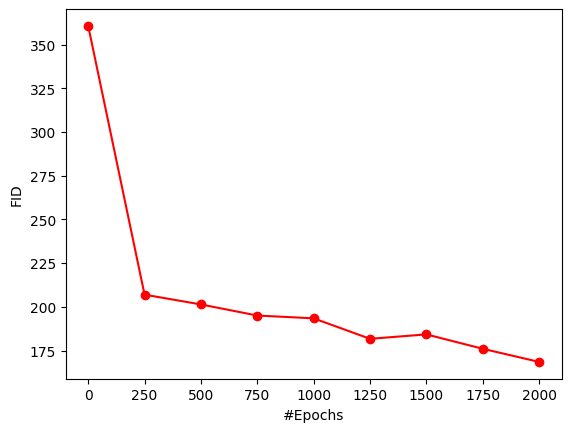

In [ ]:
x = [i * 250 for i in range(0,len(all_fid))]
plt.ylabel("FID")
plt.xlabel("#Epochs")
plt.plot(x,all_fid, 'o-r') # plot x and y using blue circle markers
plt.show()

In [ ]:
torch.save(generator, 'generatorENTIRE.pth')
torch.save(discriminator, 'discriminatorENTIRE.pth')

In [43]:
generator = torch.load('generatorENTIRE.pth')

In [ ]:
generator = torch.load('generatorENTIRE.pth')
discriminator = torch.load('discriminatorENTIRE.pth')
generator.eval()
print(summary(generator))
print(summary(discriminator))

Layer (type:depth-idx)                   Param #
Generator                                --
├─Sequential: 1-1                        --
│    └─Embedding: 2-1                    500
│    └─Linear: 2-2                       1,616
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       827,392
│    └─LeakyReLU: 2-4                    --
├─Sequential: 1-3                        --
│    └─ConvTranspose2d: 2-5              4,202,496
│    └─BatchNorm2d: 2-6                  1,024
│    └─ReLU: 2-7                         --
│    └─ConvTranspose2d: 2-8              2,097,152
│    └─BatchNorm2d: 2-9                  512
│    └─ReLU: 2-10                        --
│    └─ConvTranspose2d: 2-11             524,288
│    └─BatchNorm2d: 2-12                 256
│    └─ReLU: 2-13                        --
│    └─ConvTranspose2d: 2-14             6,144
│    └─Tanh: 2-15                        --
Total params: 7,661,380
Trainable params: 7,661,380
Non-trainable params: 0
Lay

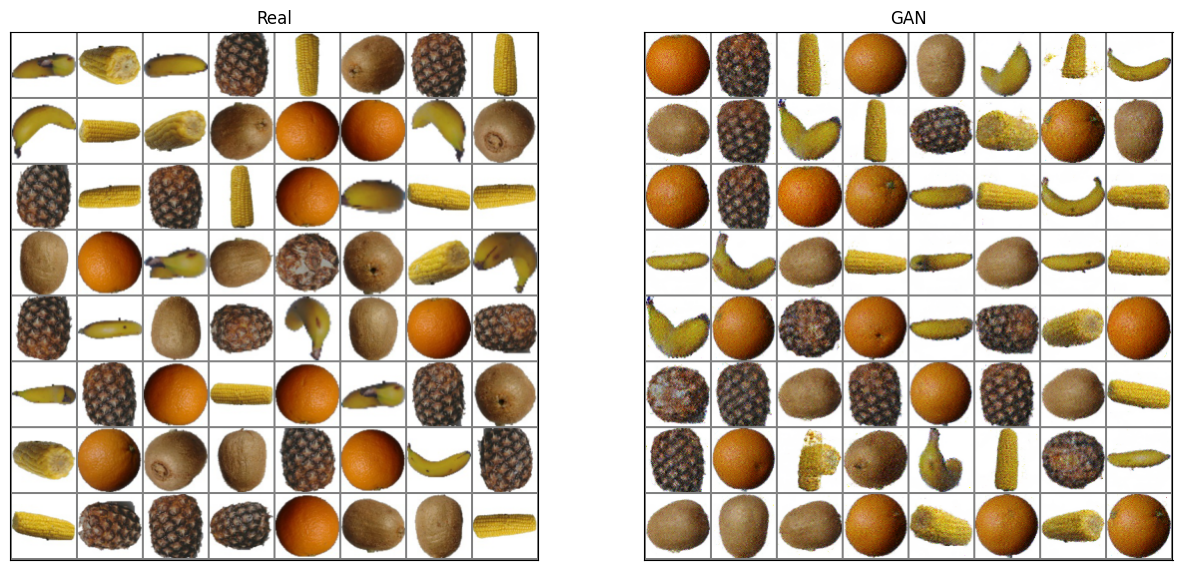

In [ ]:
grid_img_real = vutils.make_grid(next(iter(dataloader))[0], nrow=8)
grid_img_GAN = vutils.make_grid(generated_image.cpu().detach(), nrow=8)
showarray(grid_img_real.permute(1, 2, 0), grid_img_GAN.permute(1, 2, 0), title1 = "Real", title2 = "GAN")

# Classification (original dataset)

## Define train, val and test set

In [44]:
image_dir = "/tmp/Fruits"
image_size = 64
transform = T.Compose([
    T.Resize((image_size,image_size)),
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
dataset = Fruits(image_dir, transforms=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last = True, num_workers = 2)

train_size = int(len(dataset) * 0.70)
val_size = int(len(dataset)*0.15)
test_size = len(dataset) - (train_size+val_size)
train_set, val_set, test_set = random_split(dataset, [train_size , val_size, test_size])

print(f'Training set size: {train_size}\nValidation set size: {val_size}\nTest set size: {test_size}')

# Dataloader for train val and test
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, drop_last = True, num_workers = 2) #collate_fn = collate_fn
val_loader = DataLoader(val_set, batch_size=8, shuffle=False,  drop_last = False, num_workers = 2) #collate_fn = collate_fn
test_loader = DataLoader(test_set, batch_size=8, shuffle=False,  drop_last = False, num_workers = 2)

Training set size: 1662
Validation set size: 356
Test set size: 357


## Train

In [45]:
class SeqCNN(nn.Module):

    # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
       # Layer 1
        nn.Conv2d(in_channels=3, out_channels=3, kernel_size=9, padding=0, stride=1),
   #     nn.BatchNorm2d(64),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=3, out_channels=3, kernel_size=9, padding=0, stride=1),
  #      nn.BatchNorm2d(64),
        nn.ReLU(),
        # Layer 3
  #      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
   #     nn.BatchNorm2d(128),
   #     nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        # Layer 4
   #     nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
   #     nn.BatchNorm2d(256),
   #     nn.ReLU(),
  #      nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 5
   #     nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
  #      nn.BatchNorm2d(256),
   #     nn.ReLU(),
    #    nn.MaxPool2d(kernel_size=2, stride=2), 
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x
seq_net = SeqCNN()
img_x, _, _ = train_set[0]
img_x = img_x.unsqueeze(dim=0)
output = seq_net(img_x)
print(output.shape)
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

torch.Size([1, 3, 24, 24])
1728


In [46]:
class CNN(nn.Module):
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
       # Layer 1
        nn.Conv2d(in_channels=3, out_channels=3, kernel_size=9, padding=0, stride=1),
   #     nn.BatchNorm2d(64),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=3, out_channels=3, kernel_size=9, padding=0, stride=1),
  #      nn.BatchNorm2d(64),
        nn.ReLU(),
        # Layer 3
  #      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
   #     nn.BatchNorm2d(128),
   #     nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        # Layer 4
   #     nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
   #     nn.BatchNorm2d(256),
   #     nn.ReLU(),
  #      nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 5
   #     nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
  #      nn.BatchNorm2d(256),
   #     nn.ReLU(),
    #    nn.MaxPool2d(kernel_size=2, stride=2), 
    )
    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(out_features, 10),  #out features è il numero di neuroni che in ouput dalla cnn servono nel fc, sarebbe 4096
        nn.ReLU(),
        # the final Classification Layer
        nn.Linear(10, 5)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)     # x has size [B,3,24,24]; before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1)  # now x has size [B, 1728]
    output = self.fc_layers(x) # [B, 1728] --> [B, 10] --> [B, 5]
    return output

model = CNN()
# Define an optimizier
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# Define a loss 
criterion = nn.CrossEntropyLoss()

In [17]:
def train(net, loaders, optimizer, criterion, epochs=5, dev=torch.device('cpu')):
    start_time = time.time() #(for showing time)
    try:
        net = net.to(dev)
    #    print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []} #, "test": []
        history_accuracy = {"train": [], "val": [], "test": []}  #, "test": []
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0,"test": 0}  #,"test": 0
            sum_accuracy = {"train": 0, "val": 0,"test": 0}  #,"test": 0
            # Process each split
            for split in ["train", "val", "test"]:  #, "test"
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels, _) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    outputs = net(input)
                    loss = criterion(outputs, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    preds = torch.argmax(outputs, 1)
                    batch_accuracy = (preds == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}  #, "test"
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}  #, "test"
            # Update history
            for split in ["train", "val", "test"]:   #, "test"
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrACC={epoch_accuracy['train']:.4f},",
                  f"TrLoss={epoch_loss['train']:.4f} ||",
                  f"ValACC={epoch_accuracy['val']:.4f},",
                  f"ValLoss={epoch_loss['val']:.4f} ||",
                  f"TestACC={epoch_accuracy['test']:.4f},",
                  f"TestLoss={epoch_loss['test']:.4f} ||",
                  f"Overall time:{str(datetime.timedelta(seconds=int(time.time()- start_time)))}")       
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:  #, "test"
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:  #, "test"
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()

# Define dictionary of loaders
loaders = {"train": train_loader,  #train_data_loader.
           "val": val_loader,   #test_data_loader
           "test": test_loader}

Epoch 1: TrACC=0.8237, TrLoss=0.4273 || ValACC=0.8972, ValLoss=0.1486 || TestACC=0.9222, TestLoss=0.1231 || Overall time:0:00:04
Epoch 2: TrACC=0.9656, TrLoss=0.1064 || ValACC=0.9889, ValLoss=0.0348 || TestACC=0.9917, TestLoss=0.0243 || Overall time:0:00:09
Epoch 3: TrACC=0.9843, TrLoss=0.0533 || ValACC=0.9694, ValLoss=0.1204 || TestACC=0.9750, TestLoss=0.1211 || Overall time:0:00:16
Epoch 4: TrACC=0.9879, TrLoss=0.0388 || ValACC=0.9778, ValLoss=0.0781 || TestACC=0.9861, TestLoss=0.0593 || Overall time:0:00:20
Epoch 5: TrACC=0.9970, TrLoss=0.0106 || ValACC=1.0000, ValLoss=0.0022 || TestACC=0.9972, TestLoss=0.0074 || Overall time:0:00:23


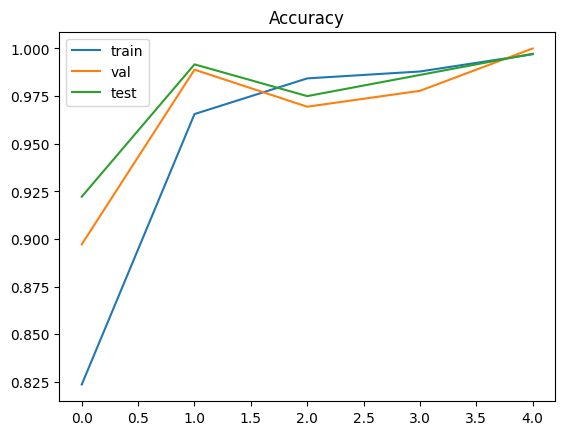

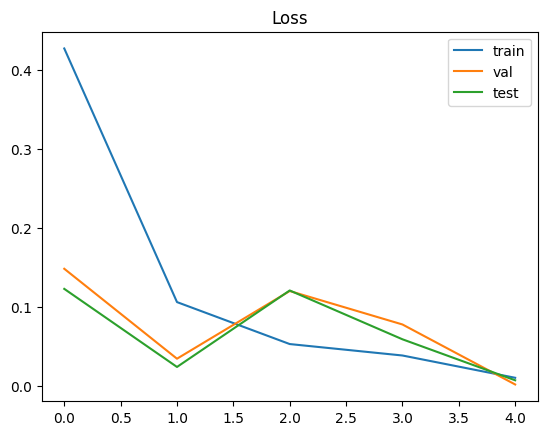

In [18]:
train(model, loaders, optimizer, criterion, epochs=5, dev=dev)

# Classification (with Gan)

## Generate 100 images for each class

In [26]:
if os.path.exists("Fake_images_for_classification"):
  shutil.rmtree('Fake_images_for_classification')

os.makedirs('Fake_images_for_classification/train/banana')
os.makedirs('Fake_images_for_classification/train/corn')
os.makedirs('Fake_images_for_classification/train/kiwi')
os.makedirs('Fake_images_for_classification/train/orange')
os.makedirs('Fake_images_for_classification/train/pineapple')

In [27]:
label0 = torch.tensor([0]).to(dev)
label0 = label0.unsqueeze(1).long()
label1 = torch.tensor([1]).to(dev)
label1 = label1.unsqueeze(1).long()
label2 = torch.tensor([2]).to(dev)
label2 = label2.unsqueeze(1).long()
label3 = torch.tensor([3]).to(dev)
label3 = label3.unsqueeze(1).long()
label4 = torch.tensor([4]).to(dev)
label4 = label4.unsqueeze(1).long()

generator.eval()

label_list = [label0, label1, label2, label3, label4]
class_list = ['banana', 'corn', 'kiwi', 'orange', 'pineapple']

for class_idx, class_label in enumerate(class_list):
    for i in range(100):
        noise_vector = torch.randn(1, z_dim, device=dev)
        generated_single_image = generator((noise_vector, label_list[class_idx]))
        save_image(generated_single_image.data[0].detach(), f"Fake_images_for_classification/train/{class_label}/{class_label}_{i}.png", nrow=5, normalize=True)
'''
for i in range(100):
  noise_vector = torch.randn(1, z_dim, device=dev)  
  #noise_vector = noise_vector.to(dev)
  generated_single_image = generator((noise_vector, label0))
  save_image(generated_single_image.data[0].detach(), f"Fake_images_for_classification/train/banana/banana_{i}.png", nrow=5, normalize=True)

for i in range(100):
  noise_vector = torch.randn(1, z_dim, device=dev)  
  #noise_vector = noise_vector.to(dev)
  generated_single_image = generator((noise_vector, label1))
  save_image(generated_single_image.data[0].detach(), f"Fake_images_for_classification/train/corn/corn_{i}.png", nrow=5, normalize=True)

for i in range(100):
  noise_vector = torch.randn(1, z_dim, device=dev)  
  #noise_vector = noise_vector.to(dev)
  generated_single_image = generator((noise_vector, label2))
  save_image(generated_single_image.data[0].detach(), f"Fake_images_for_classification/train/kiwi/kiwi_{i}.png", nrow=5, normalize=True)

for i in range(100):
  noise_vector = torch.randn(1, z_dim, device=dev)  
  #noise_vector = noise_vector.to(dev)
  generated_single_image = generator((noise_vector, label3))
  save_image(generated_single_image.data[0].detach(), f"Fake_images_for_classification/train/orange/orange_{i}.png", nrow=5, normalize=True)

for i in range(100):
  noise_vector = torch.randn(1, z_dim, device=dev)  
  #noise_vector = noise_vector.to(dev)
  generated_single_image = generator((noise_vector, label4))
  save_image(generated_single_image.data[0].detach(), f"Fake_images_for_classification/train/pineapple/pineapple_{i}.png", nrow=5, normalize=True)
'''




## Define new dataset (original + GAN images)

In [50]:
image_dir = "Fake_images_for_classification"
dataset_GAN = Fruits(image_dir, transforms=transform)
concat_training_set = ConcatDataset([train_set, dataset_GAN])
print(f'Training set (of original training images + gan images): {len(concat_training_set)}')
concat_dataloader = DataLoader(concat_training_set, batch_size=64, shuffle=True, drop_last = True, num_workers = 2)

Training set (of original training images + gan images): 2162


## Train

In [55]:
model = CNN()
# Define an optimizier
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# Define a loss 
criterion = nn.CrossEntropyLoss()

In [56]:
def train(net, loaders, optimizer, criterion, epochs=10, dev=torch.device('cpu')):
    start_time = time.time() #(for showing time)
    try:
        net = net.to(dev)
    #    print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []} #, "test": []
        history_accuracy = {"train": [], "val": [], "test": []}  #, "test": []
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0,"test": 0}  #,"test": 0
            sum_accuracy = {"train": 0, "val": 0,"test": 0}  #,"test": 0
            # Process each split
            for split in ["train", "val", "test"]:  #, "test"
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels, _) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    outputs = net(input)
                    loss = criterion(outputs, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    preds = torch.argmax(outputs, 1)
                    batch_accuracy = (preds == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}  #, "test"
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}  #, "test"
            # Update history
            for split in ["train", "val", "test"]:   #, "test"
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrACC={epoch_accuracy['train']:.4f},",
                  f"TrLoss={epoch_loss['train']:.4f} ||",
                  f"ValACC={epoch_accuracy['val']:.4f},",
                  f"ValLoss={epoch_loss['val']:.4f} ||",
                  f"TestACC={epoch_accuracy['test']:.4f},",
                  f"TestLoss={epoch_loss['test']:.4f} ||",
                  f"Overall time:{str(datetime.timedelta(seconds=int(time.time()- start_time)))}")       
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:  #, "test"
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:  #, "test"
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()

# Define dictionary of loaders
loaders = {"train": concat_dataloader, #concat_dataloader,  
           "val": val_loader,   #val_loader_GAN
           "test": test_loader}  #test_loader_GAN

Epoch 1: TrACC=0.6222, TrLoss=0.9481 || ValACC=0.8667, ValLoss=0.3389 || TestACC=0.8778, TestLoss=0.2594 || Overall time:0:00:04
Epoch 2: TrACC=0.9233, TrLoss=0.1964 || ValACC=0.9500, ValLoss=0.1370 || TestACC=0.9833, TestLoss=0.0916 || Overall time:0:00:06
Epoch 3: TrACC=0.9598, TrLoss=0.0974 || ValACC=0.9333, ValLoss=0.1126 || TestACC=0.9694, TestLoss=0.0613 || Overall time:0:00:10
Epoch 4: TrACC=0.9796, TrLoss=0.0560 || ValACC=0.9944, ValLoss=0.0255 || TestACC=0.9944, TestLoss=0.0231 || Overall time:0:00:14
Epoch 5: TrACC=0.9948, TrLoss=0.0237 || ValACC=0.9972, ValLoss=0.0184 || TestACC=1.0000, TestLoss=0.0165 || Overall time:0:00:17


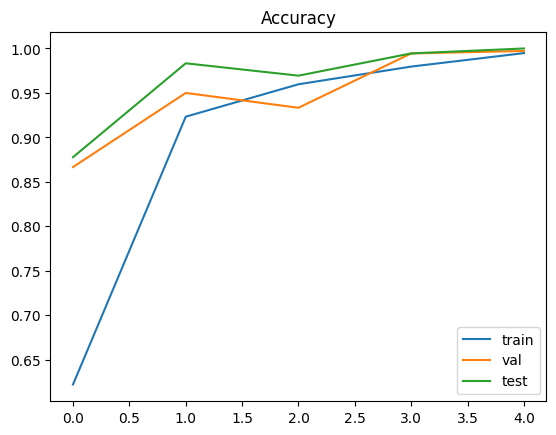

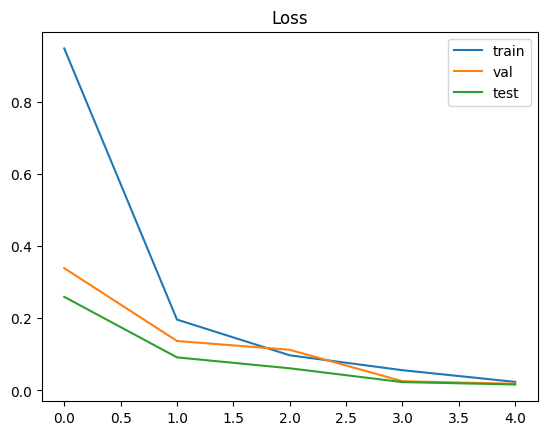

In [57]:
train(model, loaders, optimizer, criterion, epochs=5, dev=dev)

We can conclude that our GAN images are able to let the model classify the images with the same (very high) accuracy as the original dataset.

In [41]:
torch.save(model, 'model.pth')

# CAPTUM

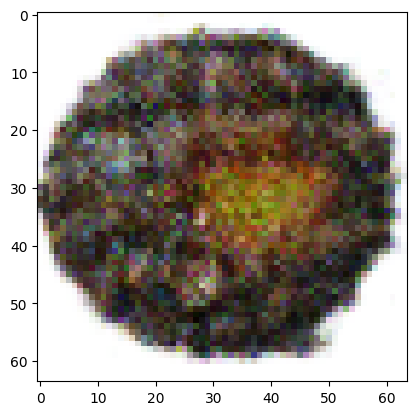

In [58]:
model = model.eval()
test_img = Image.open("Fake_images_for_classification/train/pineapple/pineapple_1.png")
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

In [70]:
transform = T.Compose([
    T.Resize((image_size,image_size)),
    T.ToTensor()
])
    
transform_norm = T.Compose([
    T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

# perform same data transforms on our own data as the model
transformed_img = transform(test_img)
input_img = transform_norm(transformed_img)
input_img = input_img.unsqueeze(dim=0).to(dev) # the model requires a dummy batch dimension

In [71]:
from captum.attr import GuidedGradCam, NoiseTunnel
from captum.attr import visualization as viz, LayerGradCam, LayerAttribution

In [72]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
print(pred_label_idx)

tensor(4, device='cuda:0')


### GradCam with noise tunnel

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_utils/visualization.py:44: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


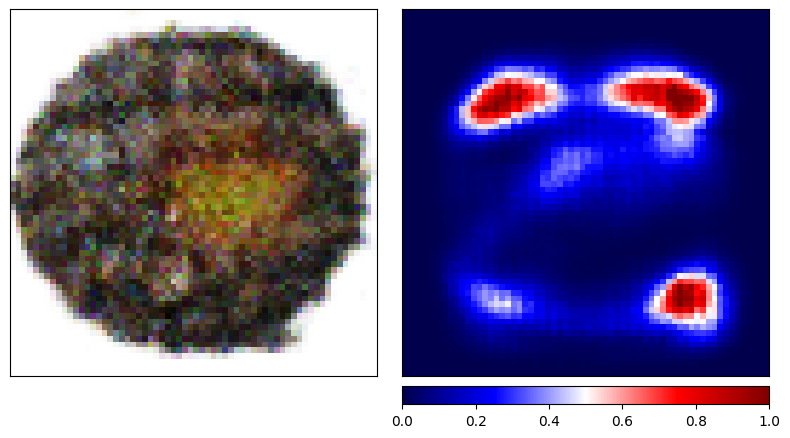

In [73]:
gg = GuidedGradCam(model, model.conv_layer[2]) #Guided GradCam on last block 
noise_tunnel = NoiseTunnel(gg) #noise tunnel on Guided GradCam
attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx, stdevs=0.4)
#visualize
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)), #noise tunneled Guided GradCam
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), #unormalized img
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

### Integrated gradient with noise tunnel

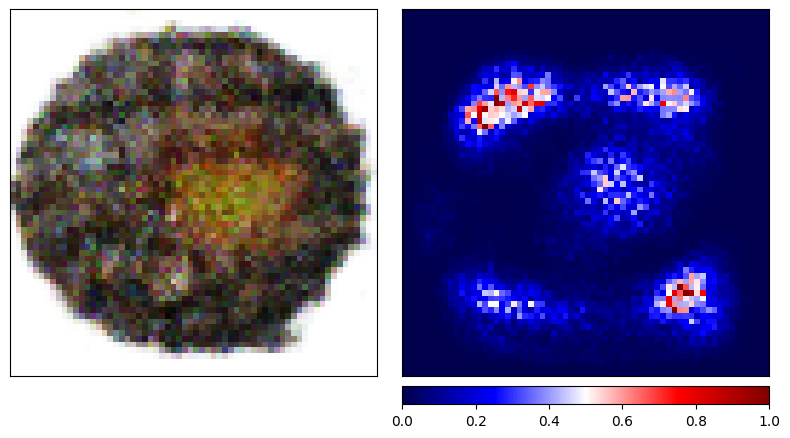

In [75]:
from captum.attr import NoiseTunnel, IntegratedGradients
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx, internal_batch_size=10)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

# CODE NOT USED (but working)

## GAN 128x128 (not used)

In [ ]:
image_size = 128
n_classes = 5
embedding_dim = 100
z_dim = 100  #latent dim
outf = "output"


transform = T.Compose([
    T.Resize((image_size,image_size)),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
dataset = Fruits(image_dir, transforms=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last = True, num_workers = 2)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
         
      
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))
         
     
        self.latent = nn.Sequential(nn.Linear(z_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))
            
 
        self.model =  nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                      nn.Tanh())
 
    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

##########################################
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
         
     
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*128*128))
              
        self.model =  nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )
 
    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

####################################
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

# Create discriminator and generator
generator = Generator().to(dev)
generator.apply(weights_init)
discriminator = Discriminator().to(dev)
discriminator.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Define the optimizers for the generator and discriminator models
G_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

def generator_loss(label, fake_output):
    gen_loss = criterion(label, fake_output)
    #print(gen_loss)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = criterion(label, output)
    #print(total_loss)
    return disc_loss

## Generate images per class 128x128

In [ ]:
#noise_vector = torch.randn(1, z_dim, device=dev)  
#noise_vector = noise_vector.to(dev)
 
#generated_image = generator((noise_vector, torch.tensor([3]).to(dev)))
#save_image(generated_image.data[0], f"Fake_images_for_classification/train/banana/corn_.png",  normalize=True)
label4 = torch.tensor([4]).to(dev)
label4 = label4.unsqueeze(1).long()

noise_vector = torch.randn(1, z_dim, device=dev)   #64 is the batch, ma è come se fossero righe e z_dim le colonne. Aggiornando sempre il noise vector, facciamo si che per ogni batch il noise di partenza sa diverso  quindi gneera immagini diverse per ogni batch
fake_imgs = generator((noise_vector,  label4))  
print(fake_imgs.size())
for idx in range(fake_imgs.shape[0]):
    fake_img= fake_imgs[idx]
    vutils.save_image(fake_img,f"Fake_images_for_classification/train/corn/cornA_.png",normalize=True)

torch.Size([1, 3, 128, 128])
